In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from tqdm import tqdm
import os


def get_test_scores_all(df, train_visits, test_visits, feature_cols, out_file):
    test_scores = {}
    params = {"C": 10, "penalty": "l2", "solver": "liblinear"}

    train_df = df[df["visit"].isin(train_visits)].reset_index(drop=True).copy()
    test_df = df[df["visit"].isin(test_visits)].reset_index(drop=True).copy()

    scaler = StandardScaler()
    train_df.loc[:, feature_cols] = scaler.fit_transform(train_df[feature_cols])
    test_df.loc[:, feature_cols] = scaler.transform(test_df[feature_cols])

    model = LogisticRegression(**params)
    model.fit(train_df[feature_cols], train_df["subject_id"])

    for visit in test_visits:
        test = test_df[test_df["visit"] == visit].reset_index(drop=True).copy()
        score = model.score(test[feature_cols], test["subject_id"])
        test_scores[visit] = score

    fname = out_file + ".xlsx"
    if not os.path.isfile(fname):
        out_df = pd.DataFrame([test_scores])
        out_df.to_excel(fname, index=False)

    return test_scores


def run_iteration(
    i, df_filtered, n, train_visits, test_visits, feature_cols, out_file, seed=None
):
    if seed is not None:
        np.random.seed(seed + i)
    subjects = np.array(df_filtered["subject_id"].unique())
    selected_subjects = np.random.choice(subjects, size=n, replace=False)
    subset_df = df_filtered[df_filtered["subject_id"].isin(selected_subjects)].copy()
    return get_test_scores_all(
        subset_df, train_visits, test_visits, feature_cols, out_file
    )


def save_results(results, out_path):
    pd.DataFrame(results).to_csv(out_path, index=False)


def run_experiment(
    df,
    feature_cols,
    ns=[50, 100],
    n_jobs=4,
    out_dir="results",
    n_iter=50,
    feat_set_name="hem",
    skip=[1, 1, 1, 1],
):
    os.makedirs(out_dir, exist_ok=True)

    for n in ns:
        print(f"\n========== Running for n = {n} ==========")
        for test_visit, s in zip([2, 3, 4, 5], skip):

            train_visits = list(range(1, test_visit))
            test_visits = list(range(test_visit, 6))

            if not s == 1:
                print(f"Skipping {train_visits} -> {test_visits}")
                continue

            visits2use = train_visits + test_visits
            df_filtered = df[df["visit"].isin(visits2use)].reset_index(drop=True)
            result_file = os.path.join(
                out_dir, f"{feat_set_name}_scores_n{n}_test{test_visit}.csv"
            )
            result_file_base = os.path.join(
                out_dir, f"{feat_set_name}_scores_n{n}_test{test_visit}"
            )

            print(
                f"\n--- Train visits: {train_visits} | Test visits: {test_visits} ---"
            )
            print(f"Saving results to: {result_file}\n")
            results = []

            for score in tqdm(
                Parallel(n_jobs=n_jobs)(
                    delayed(run_iteration)(
                        i,
                        df_filtered,
                        n,
                        train_visits,
                        test_visits,
                        feature_cols,
                        f"{result_file_base}_{i+1}",
                    )
                    for i in range(n_iter)
                ),
                total=n_iter,
                desc=f"n={n}, test_visit={test_visit}",
            ):
                results.append(score)
                save_results(results, result_file)

                # Pretty print the latest score
                formatted_score = ", ".join(
                    f"visit {k}: {v:.4f}" for k, v in score.items()
                )
                tqdm.write(f"New score added: {formatted_score}")

            print(f"\n✅ Finished: n={n}, test_visit={test_visit}")
            print(f"✅ Saved all results to {result_file}\n")

c:\Users\zita.zarandy\AppData\Local\anaconda3\envs\data\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Running the training with synthetic data

In [2]:
bp = pd.read_parquet("../data/synthetic_data_1000subjects_5visits_blood_tests.parquet")
ftir = pd.read_parquet("../data/synthetic_data_1000subjects_5visits_ftir.parquet")

merged = ftir.merge(bp, on=["subject_id", "visit"], how="inner")
merged

,1000.88098144531,1002.80944824219,1004.73791503906,1006.66638183594,1008.59484863281,1010.52337646484,1012.45184326172,1014.38031005859,1016.30877685547,1018.23724365234,...,triglycerides,total_bilirubin,total_protein,albumin,glucose,insulin,hba1c,tsh,cea,crp
0,-0.007164,-0.006765,-0.006292,-0.005785,-0.005282,-0.004807,-0.004381,-0.004025,-0.003718,-0.003413,...,2.183643,3.959154,63.436346,45.613168,4.316466,57.248464,42.682297,1.436654,2.153333,6.206506
1,-0.007196,-0.006831,-0.006387,-0.005888,-0.005367,-0.004872,-0.004436,-0.004072,-0.003755,-0.003439,...,0.736921,2.990107,73.118865,50.585246,5.384050,68.262824,41.132596,2.021172,0.868518,4.996305
2,-0.007071,-0.006701,-0.006222,-0.005691,-0.005159,-0.004659,-0.004221,-0.003862,-0.003556,-0.003248,...,0.736734,7.793022,71.190126,47.494065,5.311574,48.328595,40.375059,1.523368,1.612889,-0.743568
3,-0.007079,-0.006705,-0.006242,-0.005722,-0.005203,-0.004722,-0.004292,-0.003921,-0.003601,-0.003286,...,0.569265,4.887308,71.888208,45.982289,5.283627,64.233879,45.896200,1.752025,2.120333,5.325083
4,-0.006571,-0.006203,-0.005745,-0.005220,-0.004683,-0.004176,-0.003719,-0.003332,-0.003006,-0.002686,...,0.415561,9.806163,71.911414,50.317141,4.209672,29.192360,42.432075,1.976889,2.326466,6.392680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.006435,-0.006077,-0.005645,-0.005172,-0.004692,-0.004243,-0.003852,-0.003505,-0.003192,-0.002899,...,0.186093,19.028448,72.502076,50.079820,4.756535,11.641075,36.870255,3.167957,-0.169893,0.327425
4996,-0.006509,-0.006175,-0.005760,-0.005297,-0.004829,-0.004388,-0.003988,-0.003642,-0.003347,-0.003069,...,1.519433,20.022453,72.147577,48.252815,4.759788,14.965243,41.358565,1.890260,-0.136616,4.134869
4997,-0.006898,-0.006557,-0.006138,-0.005671,-0.005193,-0.004738,-0.004320,-0.003939,-0.003597,-0.003278,...,1.429206,10.663877,67.966158,43.482430,3.394795,-5.338420,41.463746,1.510550,0.713280,-1.074205
4998,-0.006722,-0.006395,-0.005994,-0.005537,-0.005068,-0.004614,-0.004199,-0.003833,-0.003515,-0.003223,...,1.465633,14.674040,71.229006,47.102031,5.309982,20.238480,37.409653,2.528607,-0.038512,3.821072


In [3]:
ftir_cols = [col for col in merged.columns if col[0].isdigit()]
hem_cols = [
    "hemoglobin",
    "hematocrit",
    "white_blood_cells",
    "platelet_count",
    "ast",
    "alt",
    "ggt",
    "lactate_dehydrogenase",
    "creatinine",
    "egfr",
    "sodium",
    "potassium",
    "calcium",
    "chloride",
    "total_cholesterol",
    "ldl_cholesterol",
    "hdl_cholesterol",
    "triglycerides",
    "total_bilirubin",
    "total_protein",
    "albumin",
    "glucose",
    "insulin",
    "hba1c",
    "tsh",
    "cea",
    "crp",
]

In [4]:
feature_cols = hem_cols
df = merged[["subject_id", "visit"] + feature_cols]
run_experiment(
    df,
    feature_cols,
    ns=[100],
    n_jobs=-8,
    out_dir="results",
    n_iter=50,
    feat_set_name="hem",
)


========== Running for n = 100 ==========

--- Train visits: [1] | Test visits: [2, 3, 4, 5] ---
Saving results to: results\hem_scores_n100_test2.csv



n=100, test_visit=2:  36%|███▌      | 18/50 [00:00<00:00, 176.35it/s]

New score added: visit 2: 0.7600, visit 3: 0.6800, visit 4: 0.7900, visit 5: 0.7100
New score added: visit 2: 0.7700, visit 3: 0.7900, visit 4: 0.7300, visit 5: 0.7000
New score added: visit 2: 0.6600, visit 3: 0.6800, visit 4: 0.7100, visit 5: 0.6200
New score added: visit 2: 0.6600, visit 3: 0.6600, visit 4: 0.7100, visit 5: 0.6400
New score added: visit 2: 0.6800, visit 3: 0.7300, visit 4: 0.7100, visit 5: 0.6700
New score added: visit 2: 0.7500, visit 3: 0.7000, visit 4: 0.7200, visit 5: 0.7300
New score added: visit 2: 0.7100, visit 3: 0.7500, visit 4: 0.7500, visit 5: 0.7100
New score added: visit 2: 0.7800, visit 3: 0.7700, visit 4: 0.6900, visit 5: 0.7000
New score added: visit 2: 0.6900, visit 3: 0.6600, visit 4: 0.6500, visit 5: 0.6800
New score added: visit 2: 0.7300, visit 3: 0.7500, visit 4: 0.7600, visit 5: 0.8000
New score added: visit 2: 0.7400, visit 3: 0.7100, visit 4: 0.7100, visit 5: 0.6800
New score added: visit 2: 0.7400, visit 3: 0.7400, visit 4: 0.7300, visit 5:

n=100, test_visit=2: 100%|██████████| 50/50 [00:00<00:00, 208.49it/s]


New score added: visit 2: 0.6100, visit 3: 0.6500, visit 4: 0.7000, visit 5: 0.7000
New score added: visit 2: 0.7400, visit 3: 0.7000, visit 4: 0.6900, visit 5: 0.7300
New score added: visit 2: 0.7400, visit 3: 0.7400, visit 4: 0.6800, visit 5: 0.7600
New score added: visit 2: 0.7100, visit 3: 0.7000, visit 4: 0.6500, visit 5: 0.6100
New score added: visit 2: 0.6900, visit 3: 0.6900, visit 4: 0.7300, visit 5: 0.6800
New score added: visit 2: 0.6700, visit 3: 0.6500, visit 4: 0.6800, visit 5: 0.6300
New score added: visit 2: 0.6800, visit 3: 0.6400, visit 4: 0.7000, visit 5: 0.6600

✅ Finished: n=100, test_visit=2
✅ Saved all results to results\hem_scores_n100_test2.csv


--- Train visits: [1, 2] | Test visits: [3, 4, 5] ---
Saving results to: results\hem_scores_n100_test3.csv



n=100, test_visit=3:  48%|████▊     | 24/50 [00:00<00:00, 229.28it/s]

New score added: visit 3: 0.8600, visit 4: 0.8600, visit 5: 0.8600
New score added: visit 3: 0.8400, visit 4: 0.8800, visit 5: 0.8800
New score added: visit 3: 0.8500, visit 4: 0.8400, visit 5: 0.7500
New score added: visit 3: 0.8400, visit 4: 0.8600, visit 5: 0.8400
New score added: visit 3: 0.7800, visit 4: 0.8600, visit 5: 0.8400
New score added: visit 3: 0.8300, visit 4: 0.8300, visit 5: 0.8400
New score added: visit 3: 0.8400, visit 4: 0.7900, visit 5: 0.7200
New score added: visit 3: 0.9600, visit 4: 0.9100, visit 5: 0.8700
New score added: visit 3: 0.8700, visit 4: 0.8300, visit 5: 0.8200
New score added: visit 3: 0.8600, visit 4: 0.7500, visit 5: 0.8200
New score added: visit 3: 0.8900, visit 4: 0.8500, visit 5: 0.8600
New score added: visit 3: 0.8600, visit 4: 0.7800, visit 5: 0.8200
New score added: visit 3: 0.8400, visit 4: 0.8600, visit 5: 0.8600
New score added: visit 3: 0.8900, visit 4: 0.8700, visit 5: 0.7800
New score added: visit 3: 0.9200, visit 4: 0.9300, visit 5: 0.

n=100, test_visit=3: 100%|██████████| 50/50 [00:00<00:00, 246.45it/s]


New score added: visit 3: 0.9000, visit 4: 0.8500, visit 5: 0.8400
New score added: visit 3: 0.9100, visit 4: 0.8200, visit 5: 0.8000
New score added: visit 3: 0.8600, visit 4: 0.8700, visit 5: 0.7900
New score added: visit 3: 0.8800, visit 4: 0.8200, visit 5: 0.8200
New score added: visit 3: 0.8400, visit 4: 0.8100, visit 5: 0.8400
New score added: visit 3: 0.8000, visit 4: 0.8200, visit 5: 0.7900
New score added: visit 3: 0.9000, visit 4: 0.8300, visit 5: 0.8200

✅ Finished: n=100, test_visit=3
✅ Saved all results to results\hem_scores_n100_test3.csv


--- Train visits: [1, 2, 3] | Test visits: [4, 5] ---
Saving results to: results\hem_scores_n100_test4.csv



n=100, test_visit=4:  52%|█████▏    | 26/50 [00:00<00:00, 255.34it/s]

New score added: visit 4: 0.9300, visit 5: 0.9200
New score added: visit 4: 0.9100, visit 5: 0.9000
New score added: visit 4: 0.8600, visit 5: 0.8900
New score added: visit 4: 0.9000, visit 5: 0.9400
New score added: visit 4: 0.9200, visit 5: 0.9100
New score added: visit 4: 0.9100, visit 5: 0.9300
New score added: visit 4: 0.8900, visit 5: 0.9100
New score added: visit 4: 0.8800, visit 5: 0.8800
New score added: visit 4: 0.9400, visit 5: 0.8900
New score added: visit 4: 0.8800, visit 5: 0.8900
New score added: visit 4: 0.9200, visit 5: 0.8600
New score added: visit 4: 0.9300, visit 5: 0.9100
New score added: visit 4: 0.8800, visit 5: 0.8900
New score added: visit 4: 0.8900, visit 5: 0.8600
New score added: visit 4: 0.9100, visit 5: 0.9500
New score added: visit 4: 0.8800, visit 5: 0.9300
New score added: visit 4: 0.8500, visit 5: 0.8800
New score added: visit 4: 0.8800, visit 5: 0.9100
New score added: visit 4: 0.9300, visit 5: 0.9400
New score added: visit 4: 0.8900, visit 5: 0.8800


n=100, test_visit=4: 100%|██████████| 50/50 [00:00<00:00, 260.28it/s]


New score added: visit 4: 0.8700, visit 5: 0.8100
New score added: visit 4: 0.9100, visit 5: 0.8900
New score added: visit 4: 0.8700, visit 5: 0.9100

✅ Finished: n=100, test_visit=4
✅ Saved all results to results\hem_scores_n100_test4.csv


--- Train visits: [1, 2, 3, 4] | Test visits: [5] ---
Saving results to: results\hem_scores_n100_test5.csv



n=100, test_visit=5:  44%|████▍     | 22/50 [00:00<00:00, 215.91it/s]

New score added: visit 5: 0.8700
New score added: visit 5: 0.8900
New score added: visit 5: 0.9100
New score added: visit 5: 0.9100
New score added: visit 5: 0.8800
New score added: visit 5: 0.9500
New score added: visit 5: 0.8700
New score added: visit 5: 0.9700
New score added: visit 5: 0.9200
New score added: visit 5: 0.8900
New score added: visit 5: 0.9400
New score added: visit 5: 0.9600
New score added: visit 5: 0.9200
New score added: visit 5: 0.8900
New score added: visit 5: 0.8900
New score added: visit 5: 0.9300
New score added: visit 5: 0.9300
New score added: visit 5: 0.9200
New score added: visit 5: 0.9200
New score added: visit 5: 0.9200
New score added: visit 5: 0.9200
New score added: visit 5: 0.9300
New score added: visit 5: 0.9200
New score added: visit 5: 0.9600
New score added: visit 5: 0.9400
New score added: visit 5: 0.9600
New score added: visit 5: 0.9000
New score added: visit 5: 0.9300
New score added: visit 5: 0.8900
New score added: visit 5: 0.9200
New score 

n=100, test_visit=5: 100%|██████████| 50/50 [00:00<00:00, 234.72it/s]

New score added: visit 5: 0.9300
New score added: visit 5: 0.9500
New score added: visit 5: 0.9000
New score added: visit 5: 0.9400
New score added: visit 5: 0.9100
New score added: visit 5: 0.9100
New score added: visit 5: 0.9100
New score added: visit 5: 0.9300
New score added: visit 5: 0.9600
New score added: visit 5: 0.9400

✅ Finished: n=100, test_visit=5
✅ Saved all results to results\hem_scores_n100_test5.csv



In [ ]:
feature_cols = ftir_cols
df = merged[["subject_id", "visit"] + feature_cols]
run_experiment(
    df,
    feature_cols,
    ns=[100],
    n_jobs=-8,
    out_dir="results",
    n_iter=50,
    feat_set_name="ftir",
)


========== Running for n = 100 ==========

--- Train visits: [1] | Test visits: [2, 3, 4, 5] ---
Saving results to: results\ftir_scores_n100_test2.csv



New score added: visit 2: 0.5900, visit 3: 0.6500, visit 4: 0.6600, visit 5: 0.6100
New score added: visit 2: 0.6500, visit 3: 0.6400, visit 4: 0.5900, visit 5: 0.6700
New score added: visit 2: 0.7300, visit 3: 0.6600, visit 4: 0.5200, visit 5: 0.6000
New score added: visit 2: 0.6900, visit 3: 0.6600, visit 4: 0.6400, visit 5: 0.7600
New score added: visit 2: 0.6900, visit 3: 0.7100, visit 4: 0.7000, visit 5: 0.7100
New score added: visit 2: 0.7200, visit 3: 0.7200, visit 4: 0.6800, visit 5: 0.6800
New score added: visit 2: 0.6800, visit 3: 0.6600, visit 4: 0.6700, visit 5: 0.6600
New score added: visit 2: 0.6800, visit 3: 0.7200, visit 4: 0.6600, visit 5: 0.7400
New score added: visit 2: 0.7600, visit 3: 0.8100, visit 4: 0.7000, visit 5: 0.6100
New score added: visit 2: 0.6300, visit 3: 0.7300, visit 4: 0.6900, visit 5: 0.6600
New score added: visit 2: 0.6800, visit 3: 0.7100, visit 4: 0.7000, visit 5: 0.7100
New score added: visit 2: 0.6600, visit 3: 0.5900, visit 4: 0.7000, visit 5:

n=100, test_visit=2: 100%|██████████| 50/50 [00:00<00:00, 205.41it/s]


New score added: visit 2: 0.6900, visit 3: 0.5600, visit 4: 0.5800, visit 5: 0.6300
New score added: visit 2: 0.6200, visit 3: 0.6700, visit 4: 0.6600, visit 5: 0.7200
New score added: visit 2: 0.7100, visit 3: 0.7200, visit 4: 0.6600, visit 5: 0.7000
New score added: visit 2: 0.6900, visit 3: 0.6800, visit 4: 0.7300, visit 5: 0.6800
New score added: visit 2: 0.6600, visit 3: 0.7400, visit 4: 0.7100, visit 5: 0.7000
New score added: visit 2: 0.6900, visit 3: 0.6800, visit 4: 0.6300, visit 5: 0.7500
New score added: visit 2: 0.6800, visit 3: 0.6500, visit 4: 0.6200, visit 5: 0.7300
New score added: visit 2: 0.7300, visit 3: 0.7000, visit 4: 0.7000, visit 5: 0.6200
New score added: visit 2: 0.7400, visit 3: 0.5900, visit 4: 0.6200, visit 5: 0.6800
New score added: visit 2: 0.7100, visit 3: 0.6400, visit 4: 0.7000, visit 5: 0.6600
New score added: visit 2: 0.6800, visit 3: 0.6500, visit 4: 0.6700, visit 5: 0.6900
New score added: visit 2: 0.6900, visit 3: 0.6600, visit 4: 0.7400, visit 5:

New score added: visit 3: 0.8200, visit 4: 0.8800, visit 5: 0.8600
New score added: visit 3: 0.7900, visit 4: 0.8600, visit 5: 0.8600
New score added: visit 3: 0.9000, visit 4: 0.9200, visit 5: 0.8800
New score added: visit 3: 0.8900, visit 4: 0.9300, visit 5: 0.9200
New score added: visit 3: 0.8500, visit 4: 0.8900, visit 5: 0.8900
New score added: visit 3: 0.8000, visit 4: 0.9100, visit 5: 0.9100
New score added: visit 3: 0.8300, visit 4: 0.8700, visit 5: 0.8200
New score added: visit 3: 0.8300, visit 4: 0.8600, visit 5: 0.9100
New score added: visit 3: 0.9000, visit 4: 0.9300, visit 5: 0.8900
New score added: visit 3: 0.9100, visit 4: 0.8900, visit 5: 0.9000
New score added: visit 3: 0.7600, visit 4: 0.8300, visit 5: 0.8000
New score added: visit 3: 0.8300, visit 4: 0.8700, visit 5: 0.8200
New score added: visit 3: 0.7900, visit 4: 0.9100, visit 5: 0.8400
New score added: visit 3: 0.8600, visit 4: 0.8700, visit 5: 0.8500
New score added: visit 3: 0.8000, visit 4: 0.8600, visit 5: 0.

n=100, test_visit=3: 100%|██████████| 50/50 [00:00<00:00, 232.42it/s]


New score added: visit 3: 0.8500, visit 4: 0.8700, visit 5: 0.9000
New score added: visit 3: 0.8100, visit 4: 0.8600, visit 5: 0.8700
New score added: visit 3: 0.8900, visit 4: 0.8900, visit 5: 0.8800
New score added: visit 3: 0.8100, visit 4: 0.7600, visit 5: 0.8800
New score added: visit 3: 0.8900, visit 4: 0.8600, visit 5: 0.9100
New score added: visit 3: 0.9000, visit 4: 0.9400, visit 5: 0.8800
New score added: visit 3: 0.8600, visit 4: 0.8600, visit 5: 0.9000
New score added: visit 3: 0.8900, visit 4: 0.8800, visit 5: 0.8600
New score added: visit 3: 0.9000, visit 4: 0.9000, visit 5: 0.8200

✅ Finished: n=100, test_visit=3
✅ Saved all results to results\ftir_scores_n100_test3.csv


--- Train visits: [1, 2, 3] | Test visits: [4, 5] ---
Saving results to: results\ftir_scores_n100_test4.csv



In [ ]:
feature_cols = hem_cols + ftir_cols
df = merged[["subject_id", "visit"] + feature_cols]
run_experiment(
    df,
    feature_cols,
    ns=[100],
    n_jobs=-8,
    out_dir="results",
    n_iter=50,
    feat_set_name="combined",
)


========== Running for n = 100 ==========

--- Train visits: [1] | Test visits: [2, 3, 4, 5] ---
Saving results to: results\combined_scores_n100_test2.csv



n=100, test_visit=2:  20%|████████████▏                                                | 10/50 [00:00<00:00, 98.37it/s]

New score added: visit 2: 0.7800, visit 3: 0.8100, visit 4: 0.7800, visit 5: 0.8300
New score added: visit 2: 0.7900, visit 3: 0.8500, visit 4: 0.8200, visit 5: 0.8000
New score added: visit 2: 0.8300, visit 3: 0.8100, visit 4: 0.8300, visit 5: 0.8100
New score added: visit 2: 0.7900, visit 3: 0.7600, visit 4: 0.8200, visit 5: 0.8100
New score added: visit 2: 0.8000, visit 3: 0.7700, visit 4: 0.7900, visit 5: 0.8400
New score added: visit 2: 0.8200, visit 3: 0.8700, visit 4: 0.7800, visit 5: 0.7800
New score added: visit 2: 0.8500, visit 3: 0.8600, visit 4: 0.8000, visit 5: 0.7500
New score added: visit 2: 0.8500, visit 3: 0.8300, visit 4: 0.8100, visit 5: 0.7900
New score added: visit 2: 0.8200, visit 3: 0.9100, visit 4: 0.7900, visit 5: 0.8500
New score added: visit 2: 0.8100, visit 3: 0.8200, visit 4: 0.7700, visit 5: 0.8000
New score added: visit 2: 0.7800, visit 3: 0.8000, visit 4: 0.7700, visit 5: 0.8100
New score added: visit 2: 0.7600, visit 3: 0.7800, visit 4: 0.8400, visit 5:

New score added: visit 2: 0.8300, visit 3: 0.7900, visit 4: 0.7900, visit 5: 0.8100
New score added: visit 2: 0.8200, visit 3: 0.8000, visit 4: 0.8100, visit 5: 0.7400
New score added: visit 2: 0.8100, visit 3: 0.8500, visit 4: 0.8800, visit 5: 0.8600
New score added: visit 2: 0.7700, visit 3: 0.8200, visit 4: 0.7900, visit 5: 0.8100
New score added: visit 2: 0.8000, visit 3: 0.7900, visit 4: 0.8600, visit 5: 0.8100
New score added: visit 2: 0.7900, visit 3: 0.8500, visit 4: 0.8000, visit 5: 0.7900
New score added: visit 2: 0.8300, visit 3: 0.8400, visit 4: 0.8500, visit 5: 0.7800
New score added: visit 2: 0.8800, visit 3: 0.8100, visit 4: 0.7700, visit 5: 0.8400
New score added: visit 2: 0.8200, visit 3: 0.8500, visit 4: 0.8300, visit 5: 0.8400
New score added: visit 2: 0.8700, visit 3: 0.8200, visit 4: 0.8500, visit 5: 0.8100
New score added: visit 2: 0.8500, visit 3: 0.8500, visit 4: 0.8700, visit 5: 0.8600
New score added: visit 2: 0.8400, visit 3: 0.8500, visit 4: 0.8000, visit 5:

n=100, test_visit=2:  74%|█████████████████████████████████████████████▏               | 37/50 [00:00<00:00, 74.96it/s]

New score added: visit 2: 0.8700, visit 3: 0.8500, visit 4: 0.8500, visit 5: 0.8300
New score added: visit 2: 0.8300, visit 3: 0.8200, visit 4: 0.8100, visit 5: 0.8200
New score added: visit 2: 0.8200, visit 3: 0.8000, visit 4: 0.8800, visit 5: 0.9100
New score added: visit 2: 0.7900, visit 3: 0.7100, visit 4: 0.7900, visit 5: 0.8400
New score added: visit 2: 0.7600, visit 3: 0.8400, visit 4: 0.7600, visit 5: 0.8500
New score added: visit 2: 0.8100, visit 3: 0.8400, visit 4: 0.8700, visit 5: 0.8000
New score added: visit 2: 0.7400, visit 3: 0.7800, visit 4: 0.8400, visit 5: 0.7900
New score added: visit 2: 0.8400, visit 3: 0.8600, visit 4: 0.8700, visit 5: 0.8900
New score added: visit 2: 0.8800, visit 3: 0.8900, visit 4: 0.8700, visit 5: 0.8600
New score added: visit 2: 0.8000, visit 3: 0.8000, visit 4: 0.7300, visit 5: 0.8300
New score added: visit 2: 0.8800, visit 3: 0.8500, visit 4: 0.8200, visit 5: 0.8000
New score added: visit 2: 0.8300, visit 3: 0.8500, visit 4: 0.7900, visit 5:

n=100, test_visit=2: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 76.93it/s]


New score added: visit 2: 0.8700, visit 3: 0.9200, visit 4: 0.9100, visit 5: 0.8700
New score added: visit 2: 0.8200, visit 3: 0.8300, visit 4: 0.8700, visit 5: 0.8500
New score added: visit 2: 0.7700, visit 3: 0.7900, visit 4: 0.7800, visit 5: 0.8100
New score added: visit 2: 0.7900, visit 3: 0.8500, visit 4: 0.7800, visit 5: 0.8500
New score added: visit 2: 0.8200, visit 3: 0.8400, visit 4: 0.8800, visit 5: 0.8800
New score added: visit 2: 0.8700, visit 3: 0.7600, visit 4: 0.8500, visit 5: 0.7800
New score added: visit 2: 0.8000, visit 3: 0.8300, visit 4: 0.8200, visit 5: 0.8000

✅ Finished: n=100, test_visit=2
✅ Saved all results to results\combined_scores_n100_test2.csv


--- Train visits: [1, 2] | Test visits: [3, 4, 5] ---
Saving results to: results\combined_scores_n100_test3.csv



n=100, test_visit=3:  24%|██████████████▍                                             | 12/50 [00:00<00:00, 110.02it/s]

New score added: visit 3: 0.9400, visit 4: 0.9900, visit 5: 0.9100
New score added: visit 3: 0.9300, visit 4: 0.9700, visit 5: 0.9400
New score added: visit 3: 0.9400, visit 4: 0.9500, visit 5: 0.9400
New score added: visit 3: 0.9100, visit 4: 0.9600, visit 5: 0.9700
New score added: visit 3: 0.9800, visit 4: 0.9500, visit 5: 0.9600
New score added: visit 3: 0.9300, visit 4: 0.9900, visit 5: 0.9800
New score added: visit 3: 0.9800, visit 4: 0.9700, visit 5: 0.9900
New score added: visit 3: 0.9700, visit 4: 0.9900, visit 5: 0.9500
New score added: visit 3: 0.9400, visit 4: 0.9300, visit 5: 0.9300
New score added: visit 3: 0.9500, visit 4: 0.9800, visit 5: 0.9800
New score added: visit 3: 0.9400, visit 4: 0.9100, visit 5: 0.9800
New score added: visit 3: 0.9900, visit 4: 0.9900, visit 5: 0.9700
New score added: visit 3: 0.9500, visit 4: 0.9400, visit 5: 0.9100
New score added: visit 3: 0.9600, visit 4: 0.9900, visit 5: 0.9700
New score added: visit 3: 0.9500, visit 4: 0.9600, visit 5: 0.

n=100, test_visit=3:  68%|█████████████████████████████████████████▍                   | 34/50 [00:00<00:00, 90.36it/s]

New score added: visit 3: 0.9300, visit 4: 0.9200, visit 5: 0.9500
New score added: visit 3: 0.9800, visit 4: 0.9600, visit 5: 0.9800
New score added: visit 3: 0.9700, visit 4: 0.9500, visit 5: 0.9700
New score added: visit 3: 0.9900, visit 4: 0.9700, visit 5: 0.9500
New score added: visit 3: 0.9800, visit 4: 0.9500, visit 5: 0.9400
New score added: visit 3: 0.9700, visit 4: 0.9900, visit 5: 0.9500
New score added: visit 3: 0.9800, visit 4: 0.9800, visit 5: 0.9700
New score added: visit 3: 0.9500, visit 4: 0.9500, visit 5: 1.0000
New score added: visit 3: 0.9300, visit 4: 0.9700, visit 5: 0.9500
New score added: visit 3: 0.9600, visit 4: 0.9400, visit 5: 0.9400
New score added: visit 3: 0.9500, visit 4: 0.9800, visit 5: 0.9600
New score added: visit 3: 0.9600, visit 4: 0.9600, visit 5: 0.9600
New score added: visit 3: 0.9100, visit 4: 0.9700, visit 5: 0.9700
New score added: visit 3: 0.9700, visit 4: 0.9900, visit 5: 0.9100
New score added: visit 3: 0.9700, visit 4: 0.9800, visit 5: 0.

n=100, test_visit=3: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 93.84it/s]


New score added: visit 3: 0.8900, visit 4: 0.9800, visit 5: 0.9500
New score added: visit 3: 0.9700, visit 4: 0.9800, visit 5: 0.9800
New score added: visit 3: 0.9500, visit 4: 0.9600, visit 5: 0.9500
New score added: visit 3: 0.9300, visit 4: 1.0000, visit 5: 0.9500
New score added: visit 3: 0.9500, visit 4: 0.9900, visit 5: 0.9700
New score added: visit 3: 0.9300, visit 4: 0.9700, visit 5: 0.9600
New score added: visit 3: 0.9700, visit 4: 0.9800, visit 5: 0.9800
New score added: visit 3: 0.9600, visit 4: 0.9900, visit 5: 0.9600
New score added: visit 3: 0.9700, visit 4: 0.9900, visit 5: 0.9800
New score added: visit 3: 0.9400, visit 4: 0.9900, visit 5: 0.9400
New score added: visit 3: 0.9700, visit 4: 0.9900, visit 5: 0.9800
New score added: visit 3: 0.9600, visit 4: 0.9300, visit 5: 0.9500
New score added: visit 3: 0.9800, visit 4: 0.9800, visit 5: 0.9900

✅ Finished: n=100, test_visit=3
✅ Saved all results to results\combined_scores_n100_test3.csv


--- Train visits: [1, 2, 3] | Te

n=100, test_visit=4:  30%|██████████████████                                          | 15/50 [00:00<00:00, 130.81it/s]

New score added: visit 4: 0.9900, visit 5: 0.9900
New score added: visit 4: 0.9600, visit 5: 0.9700
New score added: visit 4: 0.9700, visit 5: 0.9800
New score added: visit 4: 0.9800, visit 5: 0.9800
New score added: visit 4: 1.0000, visit 5: 1.0000
New score added: visit 4: 1.0000, visit 5: 0.9800
New score added: visit 4: 0.9900, visit 5: 1.0000
New score added: visit 4: 0.9500, visit 5: 0.9500
New score added: visit 4: 0.9900, visit 5: 0.9700
New score added: visit 4: 0.9900, visit 5: 0.9900
New score added: visit 4: 0.9800, visit 5: 0.9700
New score added: visit 4: 0.9800, visit 5: 1.0000
New score added: visit 4: 0.9500, visit 5: 0.9700
New score added: visit 4: 0.9700, visit 5: 1.0000
New score added: visit 4: 1.0000, visit 5: 0.9900
New score added: visit 4: 0.9800, visit 5: 0.9900
New score added: visit 4: 1.0000, visit 5: 0.9400
New score added: visit 4: 0.9900, visit 5: 0.9800
New score added: visit 4: 0.9900, visit 5: 1.0000
New score added: visit 4: 1.0000, visit 5: 1.0000


n=100, test_visit=4:  58%|██████████████████████████████████▊                         | 29/50 [00:00<00:00, 106.04it/s]

New score added: visit 4: 0.9800, visit 5: 0.9800
New score added: visit 4: 1.0000, visit 5: 0.9800
New score added: visit 4: 0.9800, visit 5: 0.9700
New score added: visit 4: 0.9900, visit 5: 1.0000
New score added: visit 4: 0.9900, visit 5: 0.9900
New score added: visit 4: 0.9900, visit 5: 0.9600
New score added: visit 4: 1.0000, visit 5: 0.9900
New score added: visit 4: 0.9600, visit 5: 0.9700
New score added: visit 4: 1.0000, visit 5: 0.9900
New score added: visit 4: 1.0000, visit 5: 0.9900
New score added: visit 4: 0.9700, visit 5: 0.9900
New score added: visit 4: 1.0000, visit 5: 1.0000
New score added: visit 4: 0.9700, visit 5: 0.9900
New score added: visit 4: 1.0000, visit 5: 1.0000


n=100, test_visit=4: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 90.57it/s]


New score added: visit 4: 0.9700, visit 5: 1.0000
New score added: visit 4: 1.0000, visit 5: 1.0000
New score added: visit 4: 0.9900, visit 5: 0.9900
New score added: visit 4: 0.9900, visit 5: 0.9900
New score added: visit 4: 1.0000, visit 5: 1.0000
New score added: visit 4: 0.9900, visit 5: 1.0000
New score added: visit 4: 0.9800, visit 5: 0.9900
New score added: visit 4: 0.9900, visit 5: 0.9800
New score added: visit 4: 1.0000, visit 5: 0.9800
New score added: visit 4: 0.9900, visit 5: 0.9900
New score added: visit 4: 0.9900, visit 5: 0.9900
New score added: visit 4: 1.0000, visit 5: 0.9800
New score added: visit 4: 1.0000, visit 5: 0.9900

✅ Finished: n=100, test_visit=4
✅ Saved all results to results\combined_scores_n100_test4.csv


--- Train visits: [1, 2, 3, 4] | Test visits: [5] ---
Saving results to: results\combined_scores_n100_test5.csv



New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 0.9900
New score added: visit 5: 0.9900
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 0.9800
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 0.9900
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900


n=100, test_visit=5:  80%|████████████████████████████████████████████████            | 40/50 [00:00<00:00, 110.11it/s]

New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 0.9800
New score added: visit 5: 0.9900
New score added: visit 5: 0.9900
New score added: visit 5: 0.9700
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 1.0000
New score added: visit 5: 0.9800
New score added: visit 5: 0.9800
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000
New score added: visit 5: 0.9900
New score added: visit 5: 0.9900
New score added: visit 5: 0.9900
New score added: visit 5: 1.0000


n=100, test_visit=5: 100%|████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 105.95it/s]

New score added: visit 5: 0.9800
New score added: visit 5: 1.0000
New score added: visit 5: 0.9800
New score added: visit 5: 0.9900
New score added: visit 5: 0.9900
New score added: visit 5: 0.9800
New score added: visit 5: 0.9800
New score added: visit 5: 1.0000
New score added: visit 5: 1.0000

✅ Finished: n=100, test_visit=5
✅ Saved all results to results\combined_scores_n100_test5.csv



In [ ]:
def combine_scores(filename):
    dfs = []
    for i in range(2, 6):
        fname = filename + f"{i}.csv"
        cols = [f"{i-1}_{a+i}" for a in range(6 - i)]
        df = pd.read_csv(fname)
        df.columns = cols
        dfs.append(df)
    return pd.concat(dfs, axis=1)


def save_combined_scores(filename, outfname):
    combined = combine_scores(filename)
    combined.to_excel(outfname, index=False)


save_combined_scores(r".\results\hem_scores_n100_test", r".\results\hem_v2-5_100.xlsx")
save_combined_scores(
    r".\results\ftir_scores_n100_test", r".\results\ftir_v2-5_100.xlsx"
)
save_combined_scores(
    r".\results\combined_scores_n100_test", r".\results\combined_v2-5_100.xlsx"
)

In [ ]:
bp100 = pd.read_excel(r".\results\hem_v2-5_100.xlsx")
bp100 = bp100.drop(columns=["1_3", "1_4", "1_5", "2_4", "2_5", "3_5"])
bp100.columns = ["Visit 2", "Visit 3", "Visit 4", "Visit 5"]

ftir100 = pd.read_excel(r".\results\ftir_v2-5_100.xlsx")
ftir100 = ftir100.drop(columns=["1_3", "1_4", "1_5", "2_4", "2_5", "3_5"])
ftir100.columns = ["Visit 2", "Visit 3", "Visit 4", "Visit 5"]

comb100 = pd.read_excel(r".\results\combined_v2-5_100.xlsx")
comb100 = comb100.drop(columns=["1_3", "1_4", "1_5", "2_4", "2_5", "3_5"])
comb100.columns = ["Visit 2", "Visit 3", "Visit 4", "Visit 5"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300


def draw_box_plots(
    dfs,
    columns,
    labels,
    colors=None,
    label_title=None,
    legend_loc="lower center",
    title="Multi-class classification - original data",
    ylabel="Accuracy",
    xlabel="Number of classes",
    w=0.2,
    filename="",
    ylim=(0.35, 0.95),
):

    num_measurements = len(columns)
    num_dfs = len(dfs)  # Number of dataframes (box plots per group)

    # Prepare box plot data with spacing
    data = []
    positions = []
    group_spacing = 2  # Space between measurement groups
    box_spacing = 0.3  # Space between boxes within a group

    for i, col in enumerate(columns):
        base_pos = i * group_spacing  # Start position for each measurement group

        for j in range(num_dfs):
            positions.append(base_pos + (j - (num_dfs - 1) / 2) * box_spacing)
            data.append(dfs[j][col])

    # Create Box Plot
    ax = plt.figure(figsize=(7, 5))
    box = plt.boxplot(
        data, positions=positions, patch_artist=True, showmeans=False, sym="", widths=w
    )

    if colors is None:
        colors = ["darkblue", "lightskyblue", "firebrick", "coral"]

    for i, (patch, median) in enumerate(zip(box["boxes"], box["medians"])):
        patch.set_facecolor(colors[i % num_dfs])  # FIX: Ensure correct color indexing
        median.set_color("black")  # Set median color to black

    # Set X-axis labels (one per measurement)
    xtick_positions = [i * group_spacing for i in range(num_measurements)]
    plt.xticks(xtick_positions, columns, rotation=0, ha="center", fontsize=14)
    plt.tick_params(axis="both", which="major", labelsize=14)

    # Legend
    plt.legend(
        handles=[plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_dfs)],
        labels=labels,
        ncols=1,
        fontsize=14,
        loc=legend_loc,
    )

    # Labels and Titles
    plt.ylim(ylim)
    plt.ylabel(ylabel, fontsize=26)
    plt.xlabel(xlabel, fontsize=26)
    plt.title(title, fontsize=30, pad=15)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    if filename != "":
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

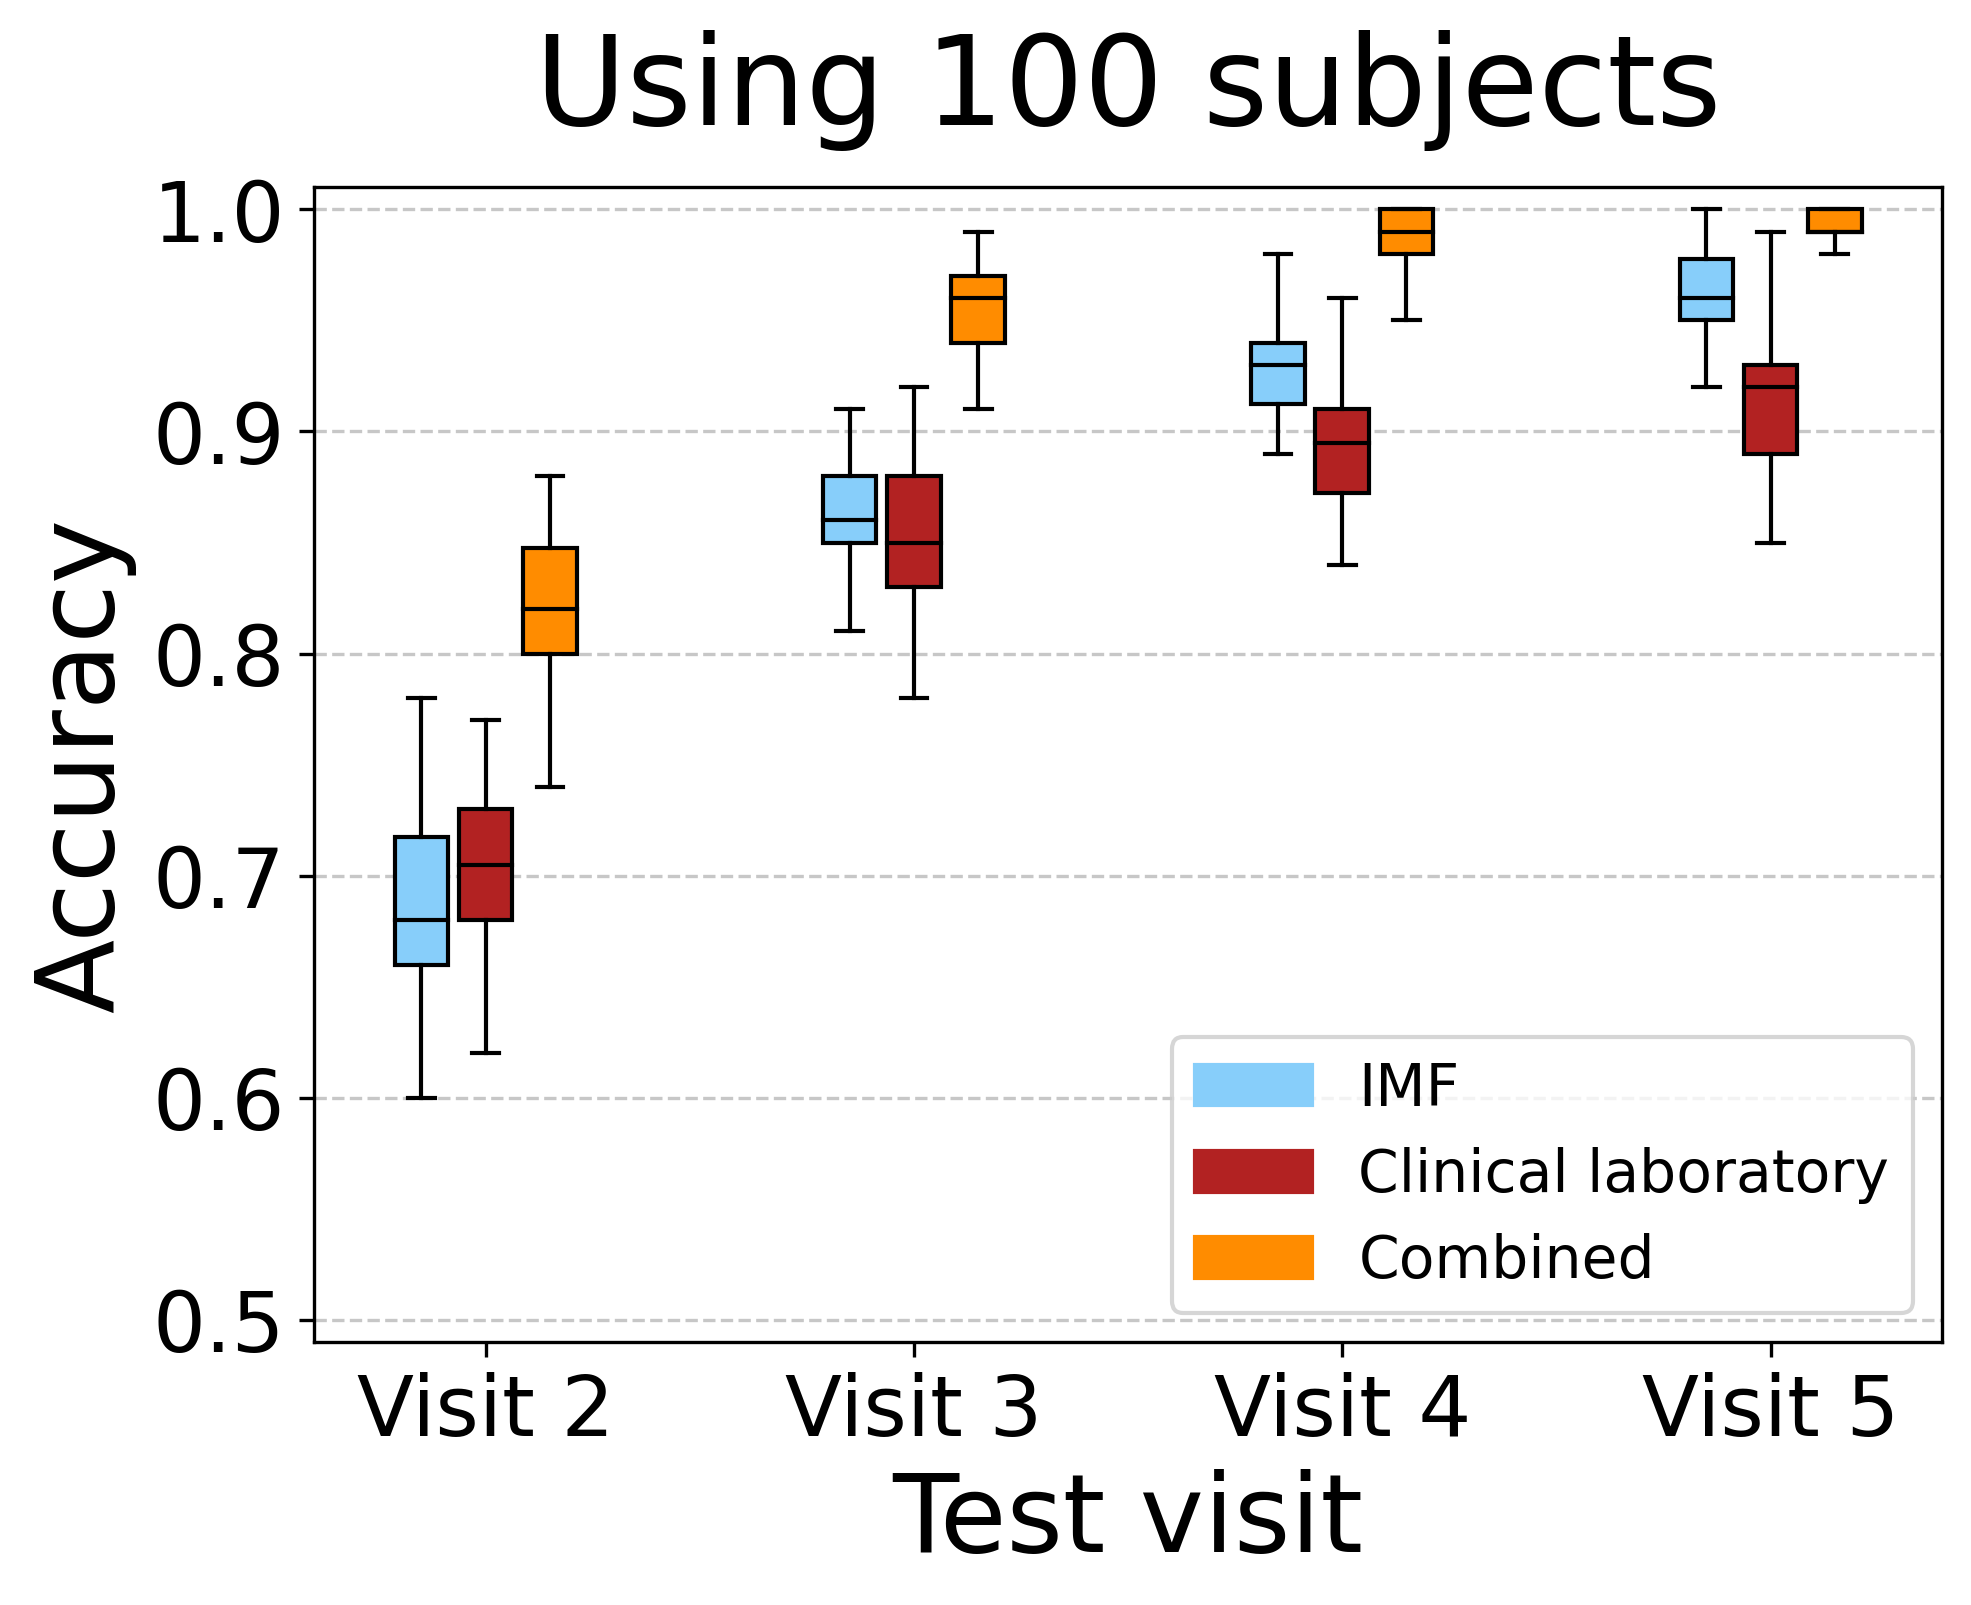

In [ ]:
draw_box_plots(
    [ftir100, bp100, comb100],
    comb100.columns,
    labels=["IMF", "Clinical laboratory", "Combined"],
    colors=["lightskyblue", "firebrick", "darkorange"],
    legend_loc="lower right",
    title="Using 100 subjects",
    ylabel="Accuracy",
    xlabel="Test visit",
    w=0.25,
    filename="./plots/n100_v2-5_synthetic.pdf",
    ylim=(0.49, 1.01),
)